<h1><b>DSC170. Predicting Asthma Rates using Using Random Forest Regression </b></h1>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1">Import packages</a></span></li><li><span><a href="#Loading-Connecticut-Asthma-data" data-toc-modified-id="Loading-Connecticut-Asthma-data-2">Loading Connecticut Asthma data</a></span><ul class="toc-item"><li><span><a href="#Variables-influencing-hospitalization-rates" data-toc-modified-id="Variables-influencing-hospitalization-rates-2.1">Variables influencing hospitalization rates</a></span></li><li><span><a href="#Training-the-sklearn's-Random-Forest-model" data-toc-modified-id="Training-the-sklearn's-Random-Forest-model-2.2">Training the sklearn's Random Forest model</a></span></li></ul></li></ul></div>

# Random Forest-based regression: Predict asthma rates



This example notebook examines childhood asthma hospitalization rates in the state of Connecticut and then builds a prediction model to use for other data. The asthma data we have is only available at the census tract level, and as is the case with much of the available public health data, some data values are missing. This notebook will show how to use the Random Forest Regressor to use known values from hospitalization rates for census tracts and build a model to predict asthma hospitalization for census tracts where the values are not known.

This is an adaptation of an ArcPy-based model that used Forest-based Classification and Regression tool in ArcGIS Pro to also predict asthma hospitalization rates for the finer-grained census block group level, using a collection of input raster layers.

With the results of this model, an organization can better allocate resources so hospitals have the staff, treatments, and educational programs necessary to effectively help families with children suffering from asthma-related complications.



## Import packages

In [1]:
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from arcgis.gis import GIS

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# login with UCSD Single-Sign-On. 
gis=GIS("https://ucsdonline.maps.arcgis.com/home", client_id="bZshlNXFuaR2KHff") 



Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://ucsdonline.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=bZshlNXFuaR2KHff&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=SKG5CT5UQWf6tQoywCWWvbVTtoQkJr&allow_verification=false


## Loading Connecticut Asthma data

<Item title:"TractswithAsthma_Projected" type:Feature Layer Collection owner:izaslavsky_ucsd>
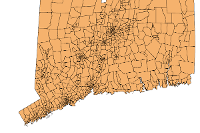

In [3]:
#Loading from featurelayer originally published from Asthma_InitialAnalysis.gdb/TractswithAsthma_Projected
item = gis.content.get("a25e5fd8d8754a6eafb3718cf18f6cf1")

flayer = item.layers[0]
item


In [4]:
# convert to a SEDF, to use with sk-learn

tract_sedf = flayer.query().sdf
tract_sedf.head()

,OBJECTID_1,ObjectID,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2010,POP10_SQMI,POP2012,...,industry_indmin_cy_p,industry_indagri_cy_p,industry_indtran_cy_p,industry_unemprt_cy,health_x8002_x_a,households_acshhbpov_p,households_acshhapov_p,Shape__Area,Shape__Length,SHAPE
0,1,12847,09,001,09001,010101,09001010101,4476,351.1,4454,...,0.0,0.55,0.0,4.1,10213.6,12.02,87.98,58195629.800781,36516.967898,"{""rings"": [[[-8198749.50791293, 5021805.129174..."
1,2,13262,09,003,09003,515101,09003515101,2555,2261.1,2536,...,0.0,0.0,3.32,5.5,3818.22,8.05,91.95,5249091.027344,12249.557415,"{""rings"": [[[-8074777.11955172, 5125740.700678..."
2,3,12848,09,001,09001,010102,09001010102,4330,330.0,4328,...,0.3,0.0,0.73,4.5,12896.88,7.19,92.81,59903263.902344,34239.539824,"{""rings"": [[[-8193156.48533997, 5027165.476578..."
3,4,12849,09,001,09001,010201,09001010201,3421,775.7,3489,...,0.0,0.0,1.88,2.6,13360.91,4.44,95.56,20128842.507812,24963.688221,"{""rings"": [[[-8196838.7210072, 5023675.2198924..."
4,5,12850,09,001,09001,010202,09001010202,5359,1402.9,5269,...,0.0,0.0,1.4,4.3,9921.79,1.24,98.76,17411850.40625,21096.757487,"{""rings"": [[[-8190039.4350668, 5020903.2334003..."


In [5]:
# we are interested in U19_rate 

tract_sedf['U19Rate']

0       <NA>
1      114.9
2       <NA>
3       <NA>
4       62.8
       ...  
824    102.2
825     54.2
826    148.4
827    118.9
828     <NA>
Name: U19Rate, Length: 829, dtype: Float64

In [6]:
tract_sedf['U19Rate'].describe()

count         591.0
mean     147.632149
std      120.577891
min            15.7
25%           58.35
50%            98.3
75%          206.35
max           771.9
Name: U19Rate, dtype: Float64

In [7]:
asthma_map = gis.map("Connecticut")
asthma_map

Map(center=[5097304.783651213, -8097191.174843919], extent={'xmin': -8181793.987846808, 'ymin': 4984872.155097…

Once we have our data in a pandas data frame, we can begin to explore it by performing some initial exploratory analyses. We begin by plotting the variable 'U19Rate', which is childhood asthma hospitalization rate, to get a sense for how its values change over space across the census tracts of Connecticut.

In [8]:
from arcgis.map.renderers import UniqueValueRenderer, UniqueValueInfo
from arcgis.map.symbols import SimpleFillSymbolEsriSFS
import numpy as np

# Calculate quantile breaks using only non-null values
n_classes = 5
valid_data = tract_sedf['U19Rate'].dropna()
breaks = np.quantile(valid_data, q=np.linspace(0, 1, n_classes+1))

# Modified arcade expression to check if value is less than 0.01 (which includes nulls)
arcade_expression = """
var value = $feature.U19Rate;
if (value == null || value <= 0.01) return 'null';
if (value <= %f) return 'q1';
else if (value <= %f) return 'q2';
else if (value <= %f) return 'q3';
else if (value <= %f) return 'q4';
else return 'q5';
""" % (breaks[1], breaks[2], breaks[3], breaks[4])

# Create unique value infos for each quantile plus null values
uv = [
    UniqueValueInfo(
        label=f"No Data (n=238)",
        symbol=SimpleFillSymbolEsriSFS(
            **{
                "type": "esriSFS",
                "color": [0, 0, 0, 255],  # Black for null values
                "outline": {
                    "type": "esriSLS",
                    "color": [128, 128, 128, 255],
                    "width": 0.5,
                    "style": "esriSLSSolid",
                },
                "style": "esriSFSSolid",
            }
        ),
        value="null"
    )
] + [
    UniqueValueInfo(
        label=f"Quantile {i+1}: {breaks[i]:.1f} - {breaks[i+1]:.1f}",
        symbol=SimpleFillSymbolEsriSFS(
            **{
                "type": "esriSFS",
                "color": [255, int(255 * (1 - (i+1)/n_classes)), 0, 255],  # Red gradient
                "outline": {
                    "type": "esriSLS",
                    "color": [128, 128, 128, 255],
                    "width": 0.5,
                    "style": "esriSLSSolid",
                },
                "style": "esriSFSSolid",
            }
        ),
        value=f"q{i+1}"
    ) for i in range(n_classes)
]

# Create the renderer
uv_rend = UniqueValueRenderer(
    unique_value_infos=uv,
    value_expression=arcade_expression
)

# Plot using spatial.plot
tract_sedf.spatial.plot(map_widget=asthma_map, renderer=uv_rend)


True

### Variables influencing hospitalization rates

We enriched the base census tract data with variables thought to influence the hospitalization rates of children under 19 affected by asthma.  The Geoerichment service added each variable as an attribute in the original feature class data, and we can now see these values in the dataframe we created.

Let's create a list of the variables we added alongside some descriptive information about what the values of the attributes mean.

In [9]:
# variables = ['healthpersonalcare_mp32001a_b_p',
#              'householdincome_pci_cy',
#              'householdincome_medhinc_cy',
#              'educationalattainment_hsgrad_cy',
#              'educationalattainment_bachdeg_c',
#              'industry_unemprt_cy',
#              'health_x8002_x_a',
#              'households_acshhbpov_p',
#              'households_acshhapov_p']

# We discarded the above list because of strong relationship between some variables



variables = ['healthpersonalcare_mp32001a_b_p',
#             'householdincome_pci_cy',
#             'householdincome_medhinc_cy',
             'educationalattainment_hsgrad_cy',
             'educationalattainment_bachdeg_c',
             'industry_unemprt_cy',
             'health_x8002_x_a',
             'households_acshhbpov_p',
#             'households_acshhapov_p']
            ]

The variables are:
<code>
healthpersonalcare_mp32001a_b_p         Smoked cigarettes in last 12 months: Percent
householdincome_pci_cy                  2018 Per Capita Income
householdincome_medhinc_cy              2018 Median Household Income
educationalattainment_hsgrad_cy_p       2018 Education: High School Diploma: Percent
educationalattainment_bachdeg_cy_p      2018 Education: Bachelor's Degree: Percent
industry_unemprt_cy                     2018 Unemployment Rate
health_x8002_x_a                        Health Insurance: Average
households_acshhbpov_p                  ACS HHs: Inc Below Poverty Level: Percent
households_acshhapov_p                  ACS HHs:Inc at/Above Poverty Level: Percent
    

We can also interact with functions from other python packages to peform a cursory examination of the relationship each of these variables have to each other. Using [`seaborn`](https://seaborn.pydata.org/), we will create a scatterplot matrix of all the variables within our data frame. This provides a sense for the relationship between these different possible explanatory variables. 

After we have explored our data, we can begin to prepare for training an initial model to see how well it predicts childhood asthma hospitialization rates based on the information we have so far for it to learn from. 

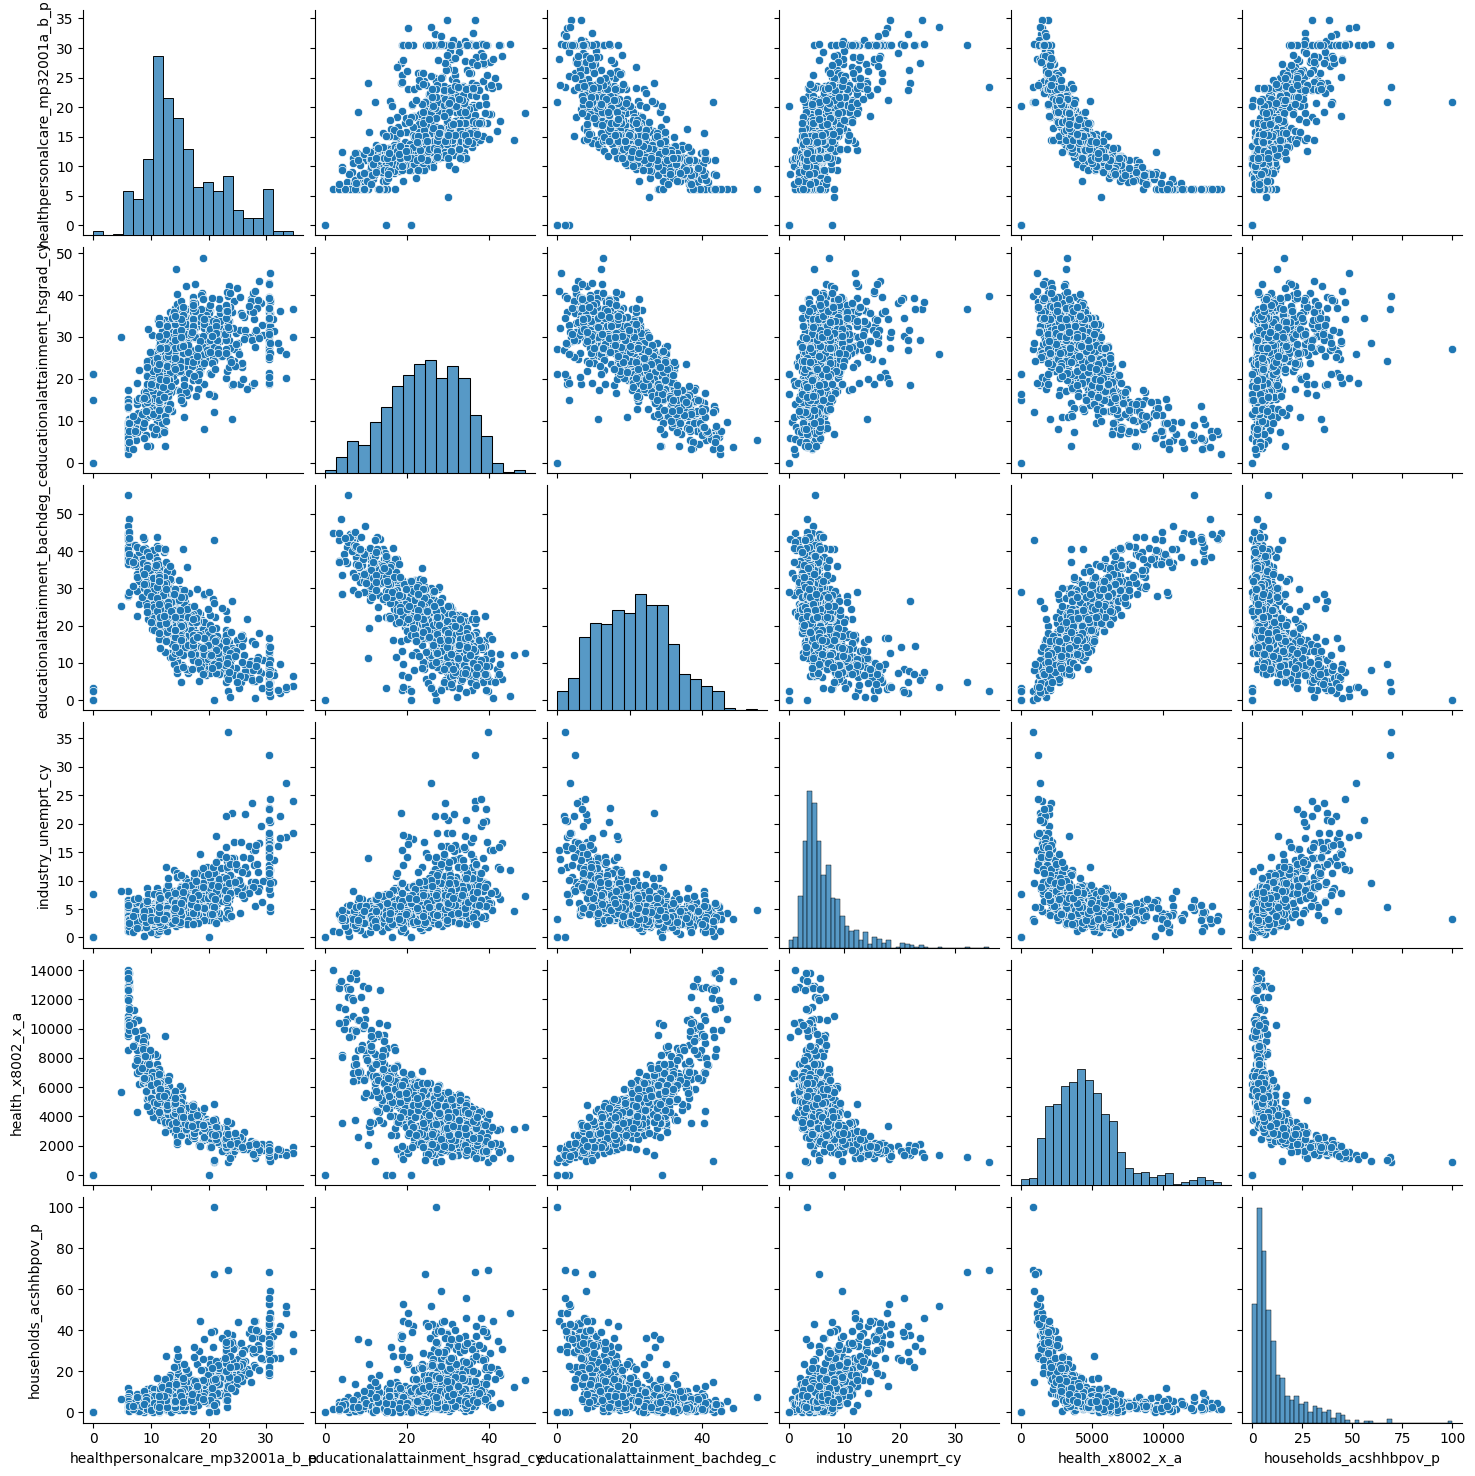

In [10]:
sns.pairplot(tract_sedf[variables])
plt.show()

### Training the sklearn's Random Forest model

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

For our model, we will use the Random Forest Regressor from sklearn. It uses the random forest algorithm to build decision trees for predicting values for unknown commodities. Random forests are versatile in the types of data they can work with and powerful in predicting outcomes. We will attempt to find a good model to predict childhood asthma hospitalization rates for census block groups.

The process of building a predictive model is iterative. It often requires multiple model runs to find the correct combination of explanatory variables and model settings that produce the best fit. The first step is to train the model for prediction. We will take advantage of the Forest-based tool's 'TRAIN' mode to try different models, settings, and options before making predictions. Training builds a forest that establishes a relationship between explanatory variables and the unknown variable we are trying to predict. The train mode allows us to save time so we don't actually run the model on unknown data until we have found a good model.

When implemented in ArcGIS Pro, the [Forest-based Classification and Regression tool](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/forestbasedclassificationregression.htm) not only uses explanatory variables from our input point or polygon feature class, but can also factor in distance features or explanatory raster layers to help increase prediction accuracy. For any input features, distance can be calculated to the nearest distance feature and used as an explanatory variable. 

In [12]:
tract_data = tract_sedf.dropna(subset=['U19Rate'])
X = tract_data[variables]
y = tract_data['U19Rate']

#splitting the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
#### Can you guess where the "random_state=42" comes from?

In [14]:
#creating the model
regr = RandomForestRegressor(n_estimators=100)

In [15]:
X.head()

,healthpersonalcare_mp32001a_b_p,educationalattainment_hsgrad_cy,educationalattainment_bachdeg_c,industry_unemprt_cy,health_x8002_x_a,households_acshhbpov_p
1,19.53,24.4,17.58,5.5,3818.22,8.05
4,8.44,11.34,37.53,4.3,9921.79,1.24
6,10.63,17.7,37.86,3.3,5881.23,4.68
7,14.11,26.02,25.2,4.7,4739.16,9.01
9,9.36,20.9,27.98,8.7,6045.64,11.38


In [16]:
#fitting the model
regr.fit(X_train[variables], y_train)

RandomForestRegressor()

**Random forest** is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

Our parameters: mostly defaults
* n_estimators=100 : the number of trees in the forest

* criterion='mse' : mean square error as the measure of the quality of the split
* max_depth = None : all trees are max depth (usually full-grown trees is the best approach, little classification error costs but one less parameter to tune)
* max_features='auto': use all features
* bootstrap = True : multiple random samplings with replacement
* max_leaf_nodes=None  : unlimited number of leaf nodes
* min_impurity_decrease=0.0 : a node will be split always (ie for any any decrease of impurity greater than or equal to 0)
* min_impurity_split=None : Not used. A threshold to stop tree growth, but we do full-grown trees)
* min_samples_leaf=1 : minimum number of samples required to be at a leaf node (self-explanatory)
* min_samples_split=2 : minimum number of samples required for a split
* min_weight_fraction_leaf=0.0 : all samples have equal weight 
* oob_score=False : score for an out-of-bag estmate (not used here)
* random_state=None :  the random number generator is by np.random
* verbose=0 : self-explanatory
* warm_start=False : fit a whole new forest 





In [17]:
# Checking R^2 error values on Train and Test sets
print(f"R^2 on Train set: {regr.score(X_train[variables], y_train)}")
print(f"R^2 on Test set: {regr.score(X_test[variables], y_test)}")

R^2 on Train set: 0.942679689867583
R^2 on Test set: 0.7309025090626569


In [18]:
# Which explanatory variables played the major roles?
print(f"""Importance of variables for decision making:\n {
            np.sort([[variables[i], regr.feature_importances_[i]] for i in range(len(variables))], axis=0)[::-1]}""")

Importance of variables for decision making:
 [['industry_unemprt_cy' '0.4424820537482043']
 ['households_acshhbpov_p' '0.26012436989663745']
 ['healthpersonalcare_mp32001a_b_p' '0.16510536089105526']
 ['health_x8002_x_a' '0.058576567354413904']
 ['educationalattainment_hsgrad_cy' '0.03766582324796365']
 ['educationalattainment_bachdeg_c' '0.03604582486172534']]


In [19]:
# checking...
X_pred = tract_sedf[tract_sedf.U19Rate.isnull()][variables + ["ObjectID"]]
X_pred

,healthpersonalcare_mp32001a_b_p,educationalattainment_hsgrad_cy,educationalattainment_bachdeg_c,industry_unemprt_cy,health_x8002_x_a,households_acshhbpov_p,ObjectID
0,6.1,15.1,38.3,4.1,10213.6,12.02,12847
2,6.11,9.22,38.24,4.5,12896.88,7.19,12848
3,6.09,7.52,38.5,2.6,13360.91,4.44,12849
5,7.36,5.35,36.73,5.5,10646.4,2.72,12851
8,12.3,7.87,39.68,3.6,6484.8,8.68,12854
...,...,...,...,...,...,...,...
803,14.23,35.0,16.88,6.2,4194.91,4.52,13650
811,14.21,29.3,18.67,5.0,4697.76,2.39,13658
816,14.23,24.94,18.67,6.0,4933.45,4.95,13663
819,11.46,30.09,18.03,5.4,4289.98,7.74,13666


In [20]:
X_pred = tract_sedf[tract_sedf.U19Rate.isnull()][variables + ["ObjectID"]]

y_pred = regr.predict(X_pred[variables])

In [21]:
tract_sedf.set_index("ObjectID")

,OBJECTID_1,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,FIPS,POP2010,POP10_SQMI,POP2012,POP12_SQMI,...,industry_indmin_cy_p,industry_indagri_cy_p,industry_indtran_cy_p,industry_unemprt_cy,health_x8002_x_a,households_acshhbpov_p,households_acshhapov_p,Shape__Area,Shape__Length,SHAPE
ObjectID,,,,,,,,,,,,,,,,,,,,,
12847,1,09,001,09001,010101,09001010101,4476,351.1,4454,349.333333,...,0.0,0.55,0.0,4.1,10213.6,12.02,87.98,58195629.800781,36516.967898,"{""rings"": [[[-8198749.50791293, 5021805.129174..."
13262,2,09,003,09003,515101,09003515101,2555,2261.1,2536,2244.247788,...,0.0,0.0,3.32,5.5,3818.22,8.05,91.95,5249091.027344,12249.557415,"{""rings"": [[[-8074777.11955172, 5125740.700678..."
12848,3,09,001,09001,010102,09001010102,4330,330.0,4328,329.878049,...,0.3,0.0,0.73,4.5,12896.88,7.19,92.81,59903263.902344,34239.539824,"{""rings"": [[[-8193156.48533997, 5027165.476578..."
12849,4,09,001,09001,010201,09001010201,3421,775.7,3489,791.156463,...,0.0,0.0,1.88,2.6,13360.91,4.44,95.56,20128842.507812,24963.688221,"{""rings"": [[[-8196838.7210072, 5023675.2198924..."
12850,5,09,001,09001,010202,09001010202,5359,1402.9,5269,1379.319372,...,0.0,0.0,1.4,4.3,9921.79,1.24,98.76,17411850.40625,21096.757487,"{""rings"": [[[-8190039.4350668, 5020903.2334003..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13671,825,09,015,09015,906100,09015906100,5132,127.9,5180,129.048331,...,0.0,1.75,3.15,6.0,3937.92,7.76,92.24,186635412.074219,64684.405163,"{""rings"": [[[-8008026.82408797, 5122940.243588..."
13672,826,09,015,09015,907100,09015907100,4413,323.1,4339,317.642753,...,0.23,0.91,4.17,8.8,3384.08,6.73,93.27,63544569.273438,41131.384493,"{""rings"": [[[-8000741.74346634, 5125621.443137..."
13673,827,09,015,09015,907200,09015907200,5506,402.2,5484,400.584368,...,0.0,0.0,6.78,6.9,3368.31,8.71,91.29,63683605.785156,35622.645248,"{""rings"": [[[-7997101.50084055, 5126199.786065..."


In [22]:
#predicting the asthma rates for Census Tracts, which orignally had no values populated
X_pred = tract_sedf[tract_sedf.U19Rate.isnull()][variables + ["ObjectID"]]

y_pred = regr.predict(X_pred[variables])

X_pred['U19Rate_pred'] = y_pred
tract_sedf.set_index("ObjectID")
X_pred.set_index("ObjectID")
tract_j = tract_sedf.join(X_pred[["ObjectID", "U19Rate_pred"]],  rsuffix="_pred")
tract_j["U19Rate_compl"] = tract_j.U19Rate.fillna(tract_j.U19Rate_pred)

In [24]:
import shap

In [25]:
print(regr.predict(X_test))  # Check the output

[272.989  96.073 185.408  86.614  37.127  70.395 113.906  72.612  78.777
  77.579 271.946 343.13   78.133  58.509 179.834  39.499 311.783  78.953
 101.148  73.821  44.079 132.286  39.311  43.015 366.208  70.407 109.635
 119.447 115.227 161.537  74.657  77.401 307.938 204.711 122.248 212.409
 109.749 276.028 111.728  60.126 266.742  72.376 211.509  73.929  74.66
  67.19  223.732  72.875  38.882  82.553 353.121  88.571  58.159 197.697
 231.475 140.033  57.288 265.28  105.147  84.25   87.819 182.107 396.249
  61.599 384.937  41.952 164.915 181.178 147.513 216.282 267.945 112.701
 170.907 159.501  66.274 131.033  34.272 392.445 285.001 345.044 330.799
  72.991 192.636 385.241  37.847  76.708 408.438  77.651  61.    293.869
  72.432  97.753 315.366 145.076  85.448  63.661 312.486 157.613  44.625
  37.852  84.057 345.466  93.028  33.565  90.032  38.285  80.789  54.502
  78.473  81.669 418.492 161.181 445.616 118.552 385.996 132.358  63.87
 115.306 386.802 100.951 107.539 104.84   86.648  62.

In [26]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer(X_test)


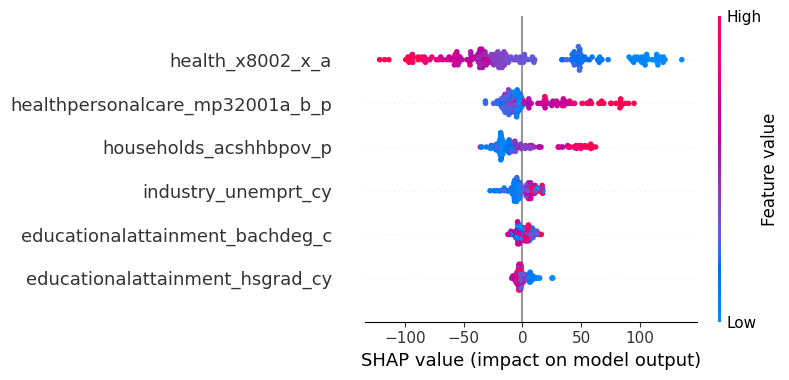

In [27]:
# Ranks features by their importance.
# Displays the distribution of SHAP values for each feature, indicating the direction (positive or negative)
# and magnitude of the feature's influence on predictions.

shap.summary_plot(shap_values, X_test)

In [28]:
tract_j[variables + ["U19Rate_compl", "SHAPE"]].head()

,healthpersonalcare_mp32001a_b_p,educationalattainment_hsgrad_cy,educationalattainment_bachdeg_c,industry_unemprt_cy,health_x8002_x_a,households_acshhbpov_p,U19Rate_compl,SHAPE
0,6.1,15.1,38.3,4.1,10213.6,12.02,62.74,"{""rings"": [[[-8198749.50791293, 5021805.129174..."
1,19.53,24.4,17.58,5.5,3818.22,8.05,114.9,"{""rings"": [[[-8074777.11955172, 5125740.700678..."
2,6.11,9.22,38.24,4.5,12896.88,7.19,57.788,"{""rings"": [[[-8193156.48533997, 5027165.476578..."
3,6.09,7.52,38.5,2.6,13360.91,4.44,27.208,"{""rings"": [[[-8196838.7210072, 5023675.2198924..."
4,8.44,11.34,37.53,4.3,9921.79,1.24,62.8,"{""rings"": [[[-8190039.4350668, 5020903.2334003..."


In [29]:
pred_map = gis.map("Connecticut")
pred_map

Map(center=[5097304.783651213, -8097191.174843919], extent={'xmin': -8181793.987846808, 'ymin': 4984872.155097…

In [30]:
from arcgis.map.renderers import UniqueValueRenderer, UniqueValueInfo
from arcgis.map.symbols import SimpleFillSymbolEsriSFS
import numpy as np

# Calculate quantile breaks
n_classes = 5
breaks = np.quantile(tract_j['U19Rate_compl'], q=np.linspace(0, 1, n_classes+1))

# Create arcade expression to classify values into quantile ranges
arcade_expression = """
var value = $feature.U19Rate_compl;
if (value <= %f) return 'q1';
else if (value <= %f) return 'q2';
else if (value <= %f) return 'q3';
else if (value <= %f) return 'q4';
else return 'q5';
""" % (breaks[1], breaks[2], breaks[3], breaks[4])

# Create unique value infos for each quantile
uv = [
    UniqueValueInfo(
        label=f"Quantile {i+1}",
        symbol=SimpleFillSymbolEsriSFS(
            **{
                "type": "esriSFS",
                "color": [255, int(255 * (1 - (i+1)/n_classes)), 0, 255],  # Red gradient
                "outline": {
                    "type": "esriSLS",
                    "color": [128, 128, 128, 255],
                    "width": 0.5,
                    "style": "esriSLSSolid",
                },
                "style": "esriSFSSolid",
            }
        ),
        value=f"q{i+1}"
    ) for i in range(n_classes)
]

# Create the renderer
uv_rend = UniqueValueRenderer(
    unique_value_infos=uv,
    value_expression=arcade_expression
)

# Plot using spatial.plot as in the example
tract_j.spatial.plot(map_widget=pred_map, renderer=uv_rend)


True

In [31]:
# let's explore what we got:
# 'U19Rate' - the original data
# 'U19Rate_pred' - our prediction
# 'U19Rate_compl' - combined original + prediction

U19vars = ['U19Rate','U19Rate_pred', 'U19Rate_compl']
tract_j[U19vars]

,U19Rate,U19Rate_pred,U19Rate_compl
0,<NA>,62.740,62.74
1,114.9,NaN,114.9
2,<NA>,57.788,57.788
3,<NA>,27.208,27.208
4,62.8,NaN,62.8
...,...,...,...
824,102.2,NaN,102.2
825,54.2,NaN,54.2
826,148.4,NaN,148.4
827,118.9,NaN,118.9
